- https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.BernoulliNB.html#sklearn.naive_bayes.BernoulliNB
- https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html


In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from ML_loader import DatasetLoader,ModelLoader


In [2]:
#Get data 
loader = DatasetLoader()
loader.read_dataset('partial_database.csv',class_path='labelsDefault.txt',separator=',')
loader.add_dataset('features_googlenet.csv')
loader.split_dataset()

#Normalize data, if not already normalized
print(np.shape(loader.X_train),np.shape(loader.X_test),np.shape(loader.y_train),np.shape(loader.y_test))

(4048, 273) (1012, 273) (4048,) (1012,)


In [3]:
#Get model
model = ModelLoader()
model.set_model(BernoulliNB())

cv = RepeatedStratifiedKFold(n_splits=22, n_repeats=3, random_state=1)

#Optimization 
param = {'alpha': np.linspace(0.5, 1.5, 100),
              'binarize': np.linspace(0, 2, 40),
              'fit_prior': [True, False]}

model.set_optimal_params(param)

model.optimize(loader.X_train,loader.y_train,cv=cv,scoring='homogeneity_score',n_iter=10)

#Train model with optimal params
model.set_model(BernoulliNB(**model.optimal_params))

Partial fit
Score accuracy group 0:  0.8167701863354038
Score accuracy group learned 0:  0.8167701863354038
Score accuracy global:  0.2717391304347826
Memory:  220.578125 MB
Partial fit
Score accuracy group 1:  0.8152173913043478
Score accuracy group learned 0:  0.782608695652174
Score accuracy group learned 1:  0.8152173913043478
Score accuracy global:  0.35177865612648224
Memory:  226.24453125 MB
Partial fit
Score accuracy group 2:  0.4891304347826087
Score accuracy group learned 0:  0.6801242236024845
Score accuracy group learned 1:  0.8152173913043478
Score accuracy group learned 2:  0.4891304347826087
Score accuracy global:  0.41007905138339923
Memory:  231.59296875 MB
Partial fit
Score accuracy group 3:  0.4492753623188406
Score accuracy group learned 0:  0.6366459627329193
Score accuracy group learned 1:  0.8043478260869565
Score accuracy group learned 2:  0.42934782608695654
Score accuracy group learned 3:  0.4492753623188406
Score accuracy global:  0.43379446640316205
Memory: 

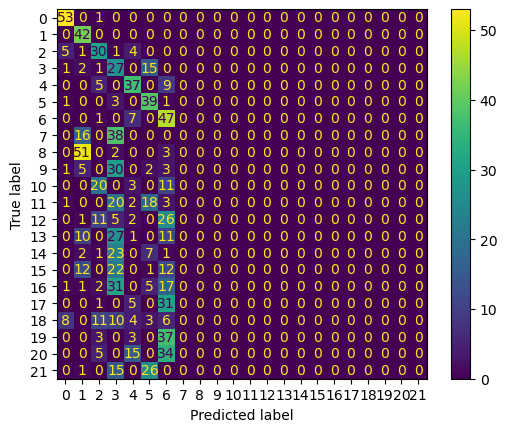

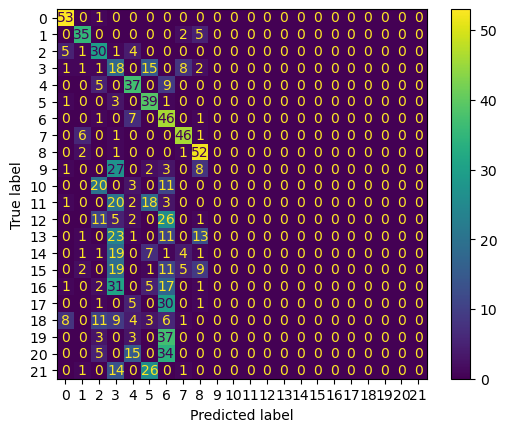

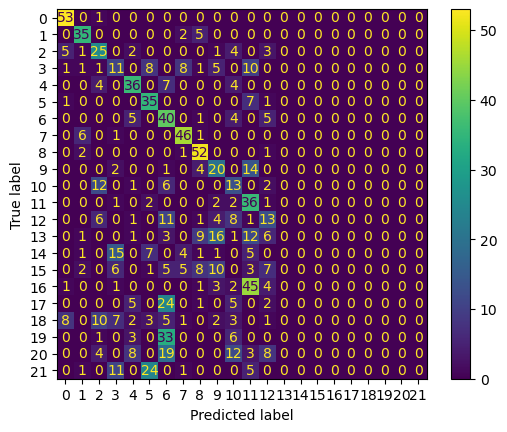

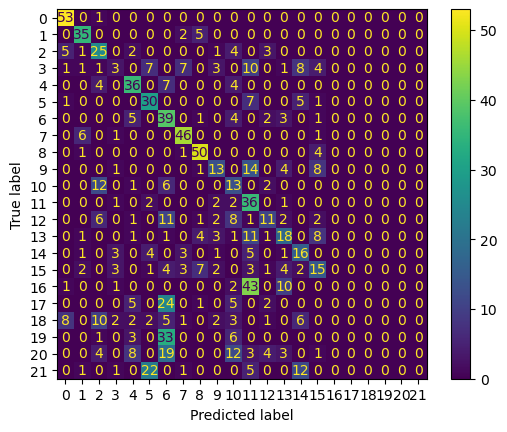

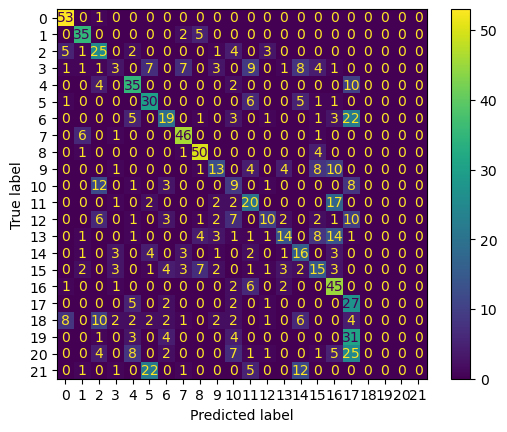

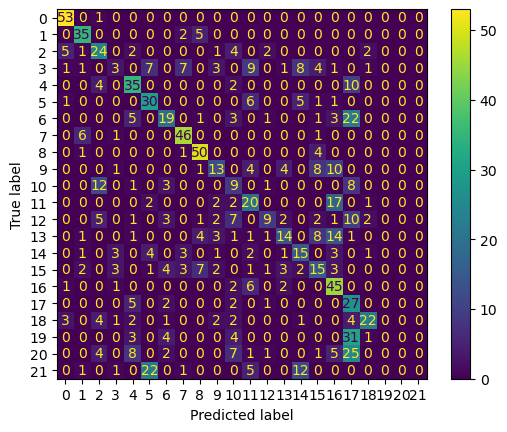

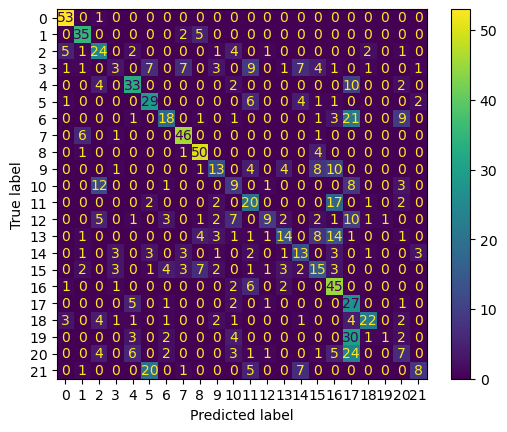

In [4]:
##Split by class, to increment by class:
class_to_group = {1:[1,2,3,4,5,6,7],2:[8,9],3:[10,11,12,13],4:[14,15,16],5:[17,18],6:[19],7:[20,21,22]}
X_train_merged, X_test_merged, y_train_merged, y_test_merged=loader.split_dataset_class(class_to_group,random_state=1)
memory_values = []
accuracy_learned_grouped = []


#Train model
for idx,(X_train,y_train,X_test,y_test) in enumerate(zip(X_train_merged,y_train_merged,X_test_merged,y_test_merged)):
    mem,res=model.partial_fit_train(X_train,y_train,classes=loader.classes)
    print(f"Score accuracy group {idx}: ",model.score(X_test,y_test))
    accuracy_learned = []
    for i in range(idx+1):
        print(f"Score accuracy group learned {i}: ",model.score(X_test_merged[i],y_test_merged[i]))
        accuracy_learned.append(model.score(X_test_merged[i],y_test_merged[i]))
    print("Score accuracy global: ",model.score(loader.X_test,loader.y_test))
    print("Memory: ",np.mean(mem),"MB")
    memory_values.append(np.mean(mem))
    accuracy_learned_grouped.append(accuracy_learned)
    y_pred=model.predict(loader.X_test)
    cm = confusion_matrix(loader.y_test, y_pred)
    ConfusionMatrixDisplay(confusion_matrix=cm).plot()

model.reset_model()

average_memory = np.mean(memory_values)
print("Average memory usage: ", average_memory,"MB")

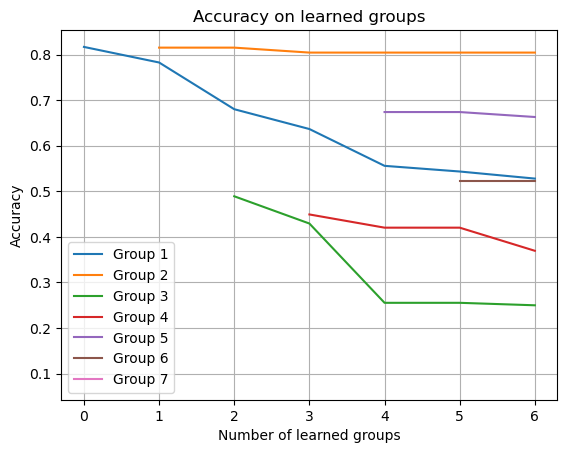

<Axes: title={'center': 'Accuracy on learned groups'}, xlabel='Number of learned groups', ylabel='Accuracy'>

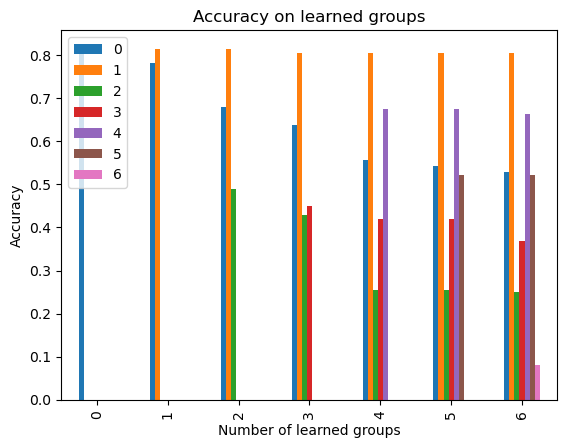

In [5]:
#Figure for accuracy on learned class
df = pd.DataFrame(accuracy_learned_grouped)
df1 = df.replace(np.nan, 0)
df=df.T

fig, ax = plt.subplots()
for i in range(len(class_to_group)):
    ax.plot(list(df.iloc[i]),label=f'Group {i+1}')

ax.set(xlabel='Number of learned groups', ylabel='Accuracy',
        title='Accuracy on learned groups')

ax.grid()
ax.legend()
plt.show()

# Bar plot 
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.set(xlabel='Number of learned groups', ylabel='Accuracy',
        title='Accuracy on learned groups')

df1.plot(kind='bar', ax=ax)

Partial fit
Score accuracy batch:  0.43280632411067194
Score accuracy global:  0.49110671936758893
Memory:  389.6100260416667 MB
Partial fit
Score accuracy batch:  0.4762845849802372
Score accuracy global:  0.49209486166007904
Memory:  373.1315104166667 MB
Partial fit
Score accuracy batch:  0.4723320158102767
Score accuracy global:  0.4950592885375494
Memory:  374.1713169642857 MB
Partial fit
Score accuracy batch:  0.45849802371541504
Score accuracy global:  0.49407114624505927
Memory:  377.1946614583333 MB
Partial fit
Score accuracy batch:  0.4624505928853755
Score accuracy global:  0.49110671936758893
Memory:  376.5390625 MB
Partial fit
Score accuracy batch:  0.47035573122529645
Score accuracy global:  0.49209486166007904
Memory:  378.9927455357143 MB
Partial fit
Score accuracy batch:  0.48023715415019763
Score accuracy global:  0.49110671936758893
Memory:  380.9654017857143 MB
Partial fit
Score accuracy batch:  0.4683794466403162
Score accuracy global:  0.4891304347826087
Memory:  3

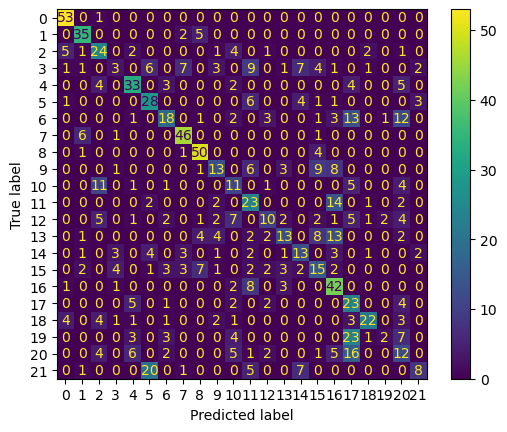

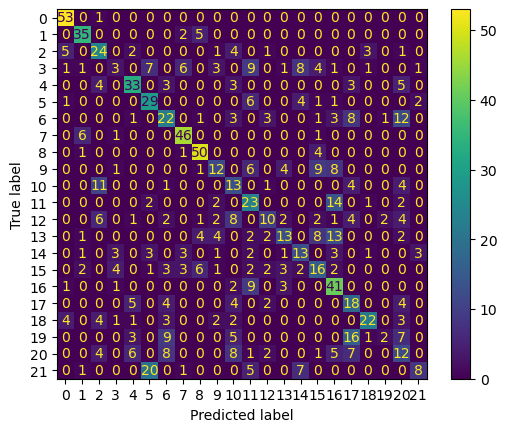

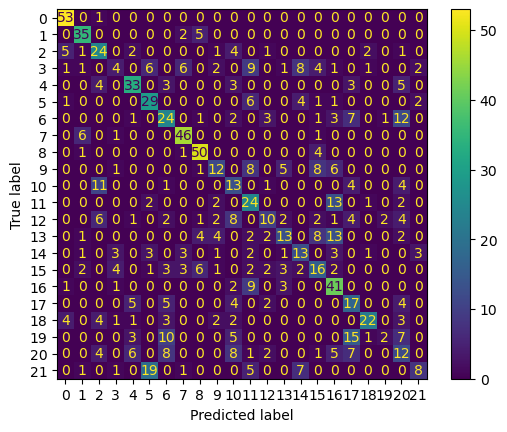

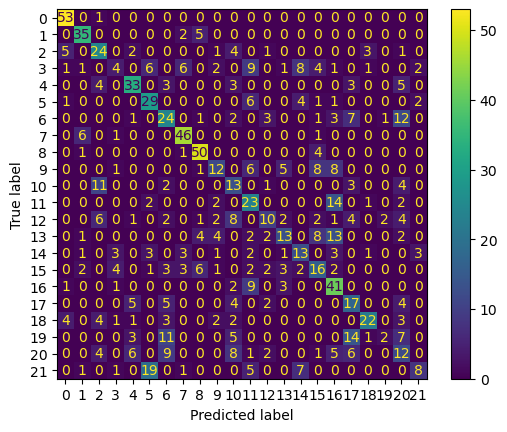

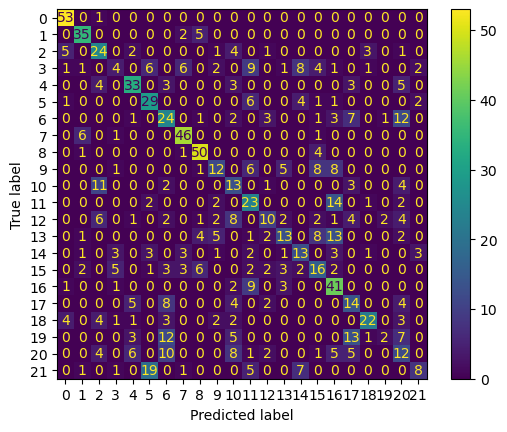

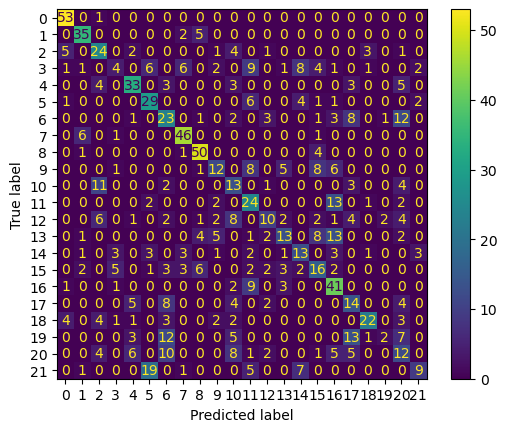

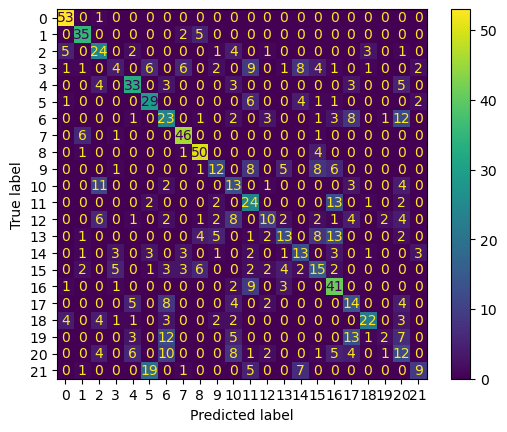

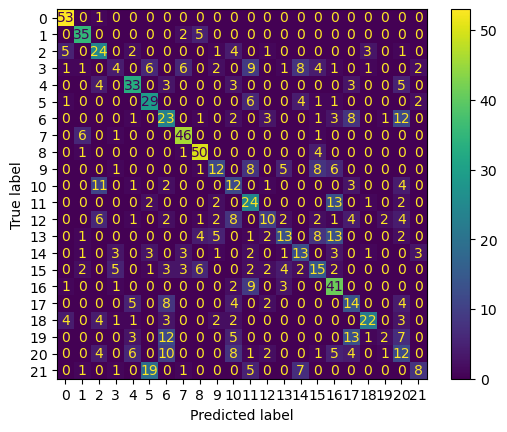

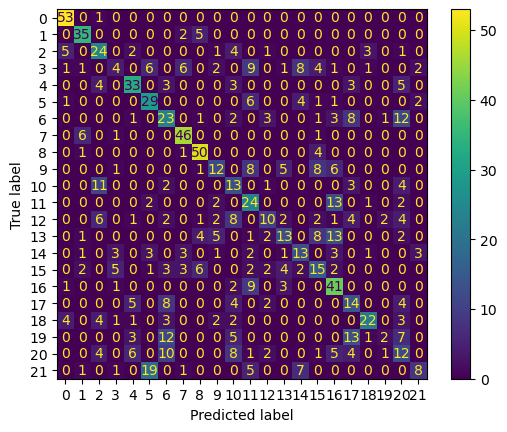

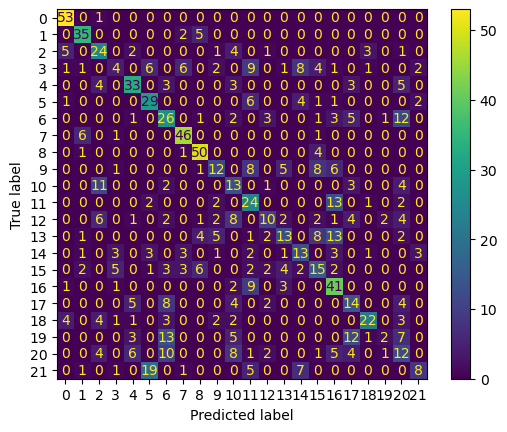

In [6]:
X_train_split_data,y_train_split_data,X_test_split_data,y_test_split_data=loader.split_dataset_data(10)
memory_values = []

for x in range(len(X_train_split_data)):
    mem,res=model.partial_fit_train(X_train_split_data[x],y_train_split_data[x],classes=loader.classes)
    print("Score accuracy batch: ",model.score(X_test_split_data[x],y_test_split_data[x]))
    print("Score accuracy global: ",model.score(loader.X_test,loader.y_test))
    print("Memory: ",np.mean(mem),"MB")
    memory_values.append(np.mean(mem))

    y_pred=model.predict(loader.X_test)
    cm = confusion_matrix(loader.y_test, y_pred)
    ConfusionMatrixDisplay(confusion_matrix=cm).plot()

model.reset_model()

average_memory = np.mean(memory_values)
print("Average memory usage: ", average_memory,"MB")